[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/image/image-search/image-search.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/image/image-search/image-search.ipynb)

# Image Search

## Background

### What is Image Search and how will we use it?

One may find themselves with an image, looking for similar images among a large image corpus. The difficult part of this requirement is instantly retrieving, at scale, similar images, especially when there are tens of millions or billions of images from which to choose.

In this example, we will walk you through the mechanics of how to solve this problem using an off-the-shelf, pretrained, neural network to generate data structures known as [vector embeddings](https://www.pinecone.io/learn/vector-embeddings/). We will use Pinecone's vector database offering to find images with similar vector embeddings to an _query image_.

### Learning Goals and Estimated Reading Time

_By the end of this 15 minute demo (on a recent MacBook Pro, or up to an hour on Google Colab), you will have:_
 1. Learned about Pinecone's value for solving realtime image search requirements!
 2. Stored and retrieved vectors from Pinecone your very-own Pinecone Vector Database.
 3. Encoded images as vectors using a pretrained neural network (i.e. no model training necessary).
 4. Queried Pinecone's Vector Database to find similar images to the query in question.
 
Once all data is encoded as vectors, and is in your Pinecone Index, results of Pinecone queries are returned, on average, in tens of milliseconds.

## Setup: Prerequisites and Image Data

### Python 3.7+

This code has been tested with Python 3.7. It is recommended to run this code in a virtual environment or Google Colab.

### Acquiring your Pinecone API Key

A Pinecone API key is required. You can obtain a complimentary key on our [our website](https://app.pinecone.io/). Either add `PINECONE_EXAMPLE_API_KEY` to your list of environmental variables, or manually enter it after running the below cell (a prompt will pop up requesting the API key, storing the result within this kernel (session)).

### Installing and Importing Prerequisite Libraries:
All prerequisites are installed and listed in the next cell.

#### Installing via `pip`

In [1]:
!pip install -qU pinecone-client \
                 torchvision \
                 seaborn \
                 tqdm \
                 httpimport \
                 requests

#### Importing and Defining Constants

In [2]:
import os
import requests

import tqdm
import httpimport
import pinecone
import numpy as np
from PIL import Image

import torch
import torchvision

DATA_DIRECTORY = 'tmp'
INDEX_NAME = 'image-search'
INDEX_DIMENSION = 1000
BATCH_SIZE=200

### Helper Module

This helper module will be imported and will enable this notebook to be self-contained.

In [3]:
# There is a helper module required for this notebook to run.
# When not present with this notebook, it will be streamed in from Pinecone's Example Repository.
# You can find the module at https://github.com/pinecone-io/examples/tree/master/image_search

if os.path.isfile('helper.py'):
    import helper as h
else:
    print('importing `helper.py` from https://github.com/pinecone-io')
    with httpimport.github_repo(
        username='pinecone-io', 
        repo='examples',
        module=['search/image/image-search'],
        branch='master'):
        from image_search import helper as h

Extracting API Key from environmental variable `PINECONE_EXAMPLE_API_KEY`...

Pinecone API Key available at `h.pinecone_api_key`

### Downloading Data

To demonstrate image search using Pinecone, we will download 100,000 small images using [built-in datasets](https://pytorch.org/vision/stable/datasets.html) available with the `torchvision` library.

In [4]:
datasets = {
    'CIFAR10': torchvision.datasets.CIFAR10(DATA_DIRECTORY, transform=h.preprocess, download=True),
    'CIFAR100': torchvision.datasets.CIFAR100(DATA_DIRECTORY, transform=h.preprocess, download=True)
}

Files already downloaded and verified
Files already downloaded and verified


### Inspecting Images
These are some of the images from what was just downloaded. If interested, read about the CIFAR image dataset [here](https://www.cs.toronto.edu/~kriz/cifar.html).

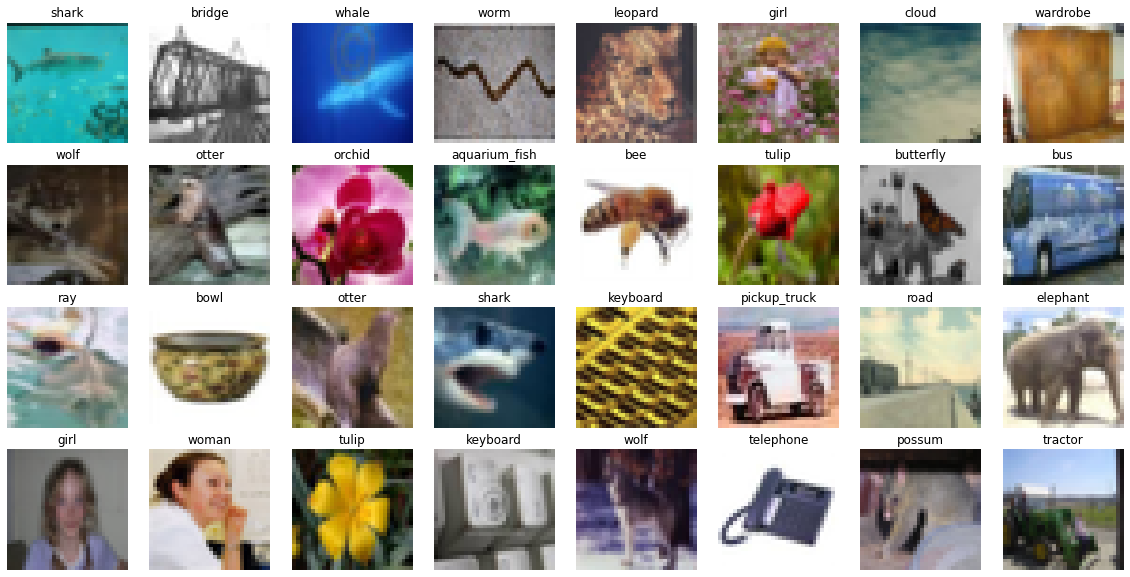

In [5]:
h.show_random_images_from_full_dataset(datasets['CIFAR100'])

## Generating Embeddings and Sending them to Pinecone

### Loading a Pretrained Computer Vision Model

We will use a pretrained model that, like the dataset above, is shipped with PyTorch. This model will create a 1000-dimensional sequence of floats for each input image. We will use this output as an embedding associated with an image.

In [6]:
model = torchvision.models.squeezenet1_1(pretrained=True).eval()

### Why SqueezeNet?

We chose the [SqueezeNet](https://en.wikipedia.org/wiki/SqueezeNet) model because it is a very small model and basic model that has been trained on [millions of images](https://en.wikipedia.org/wiki/ImageNet) across 1000 classes. It is easy to instantiate with one line of code and generates embeddings quite a bit faster than deeper models.

### On Comparing Embeddings

Two embeddings might look like something like this:

- \[-0.02, 0.06, 0.0, 0.01, 0.08, -0.03, 0.01, 0.02, 0.01, 0.02, -0.07, -0.11, -0.01, 0.08, -0.04\]
- \[-0.04, -0.09, 0.04, -0.1, -0.05, -0.01, -0.06, -0.04, -0.02, -0.04, -0.04, 0.07, 0.03, 0.02, 0.03\]

In order to determine how similar they are, we use a [simple](https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d) formula that takes a very short time to compute. Similarity scores are, in general, an excellent proxy for image similarity.

### Creating Our Pinecone Index

The process for creating a Pinecone Index requires your Pinecone API key, the name of your index, and the number of dimensions of each vector (1000).

In this example, to compare embeddings, we will use the [cosine similarity score](https://en.wikipedia.org/wiki/Cosine_similarity) because this model generates un-normalized probability vectors. While this calculation is trivial when comparing two vectors, it will take quite a long time when needing to compare a query vector against millions or billions of vectors and determine those most similar with the query vector.

### What is Pinecone for?

There is often a technical requirement to compare one vector to tens or hundreds of millions or more vectors, to do so with low latency (less than 50ms) and a high throughput. Pinecone solves this problem with its managed vector database service, and we will demonstrate this below.

In [7]:
# authenticate with Pinecone API, keys available at your project at https://app.pinecone.io
pinecone.init(
    h.pinecone_api_key,
    environment="YOUR_ENV"  # find next to API key in console
)
# if the index does not already exist, we create it
if INDEX_NAME not in pinecone.list_indexes():
    pinecone.create_index(name=INDEX_NAME, dimension=INDEX_DIMENSION)
# instantiate connection to your Pinecone index
index = pinecone.Index(INDEX_NAME)

### Preparing Vector Embeddings

We will encode the downloaded images for upload to Pinecone, and store the associated class of each image as metadata.

#### Creating Vector IDs
Each vector ID will have a prefix corresponding to _CIFAR10_ or _CIFAR100_.

In [8]:
def get_vector_ids(batch_number, batch_size, prefix):
    """Return vector ids."""
    start_index = batch_number * batch_size
    end_index = start_index + batch_size
    ids = np.arange(start_index, end_index)
    # create id based on prefix 
    # eg. if id == 5, prefix == 'CIFAR10', then create 'CIFAR10.5' as vector id.
    ids_with_prefix = map(lambda x: f'{prefix}.{str(x)}', ids)
    return ids_with_prefix

#### Creating metadata for each vector containing class label

In [9]:
def get_vector_metadata(label_indices, class_list):
    """Return list of {'label': <class name>}."""
    get_class_name = lambda index: {'label': class_list[index]}
    return map(get_class_name, label_indices)

#### Constructing Vector Embeddings

In a Pinecone Vector Database, there are three components to every Pinecone vector embedding:

 - a vector ID
 - a sequence of floats of a user-defined, fixed dimension
 - vector metadata (a key-value mapping, used for filtering at runtime)

In [10]:
def get_vectors_from_batch(preprocessed_data, label_indices, batch_number, dataset):
    """Return list of tuples like (vector_id, vector_values, vector_metadata)."""
    num_records = len(preprocessed_data)
    prefix = dataset.__class__.__name__
    with torch.no_grad():
        # generate image embeddings with PyTorch model
        vector_values = model(preprocessed_data).tolist()
    # return respective IDs/metadata for each image embedding
    vector_metadata = get_vector_metadata(label_indices, dataset.classes)
    vector_ids = get_vector_ids(batch_number, num_records, prefix)
    return list(zip(vector_ids, vector_values, vector_metadata))

#### Example Vector Embedding
The below code is an example of a vector embedding, showing just the first 3 components of the associated vector.

In [11]:
dataset = datasets['CIFAR100']
list_of_preprocessed_tensors, label_indices = list(zip(*[dataset[i] for i in range(BATCH_SIZE)]))
preprocessed_data = torch.stack(list_of_preprocessed_tensors)
vectors = get_vectors_from_batch(preprocessed_data, label_indices, 0, dataset)
id_, embedding, metadata = vectors[123]
print(id_, embedding[:3], metadata, sep=', ')

CIFAR100.123, [4.237038612365723, 11.179943084716797, 1.3662679195404053], {'label': 'orange'}


#### Upsert Vectors to Pinecone
This function iterates through a dataset in batches, generates a list of vector embeddings (as in the the above example) and upserts in batches to Pinecone.

In [12]:
def upsert_image_embeddings(dataset, pinecone_index, batch_size=BATCH_SIZE, num_rows=None):
    """Iterate through dataset, generate embeddings and upsert in batches to Pinecone index.
    
    Args:
     - dataset: a PyTorch Dataset
     - pinecone_index: your Pinecone index
     - batch_size: batch size
     - num_rows: Number of initial rows to use of dataset, use all rows if None. 
    """
    if num_rows > len(dataset):
        raise ValueError(f'`num_rows` should not exceed length of dataset: {len(dataset)}')
    if num_rows:
        sampler = range(num_rows)
    else:
        sampler = None
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler)
    tqdm_kwargs = h.get_tqdm_kwargs(dataloader)
    for batch_number, (data, label_indices) in tqdm.notebook.tqdm(enumerate(dataloader), **tqdm_kwargs):
        vectors = get_vectors_from_batch(
            data, 
            label_indices, 
            batch_number, 
            dataloader.dataset)
        pinecone_index.upsert(vectors)

### Begin Upsert for all 100,000 Images
One progress bar is generated per dataset. Truncate number of rows in each dataset by modifying `num_rows` parameter value in the cell below. Each of the CIFAR datasets have 50,000 rows.

In [13]:
for dataset in datasets.values():
    upsert_image_embeddings(dataset, index, num_rows=50_000)

  0%|          | 0/250 [00:00<?, ?chunk of 200 CIFAR10 vectors/s]

  0%|          | 0/250 [00:00<?, ?chunk of 200 CIFAR100 vectors/s]

### View Progress On The [Pinecone Console](https://app.pinecone.io) (sample screenshot below)

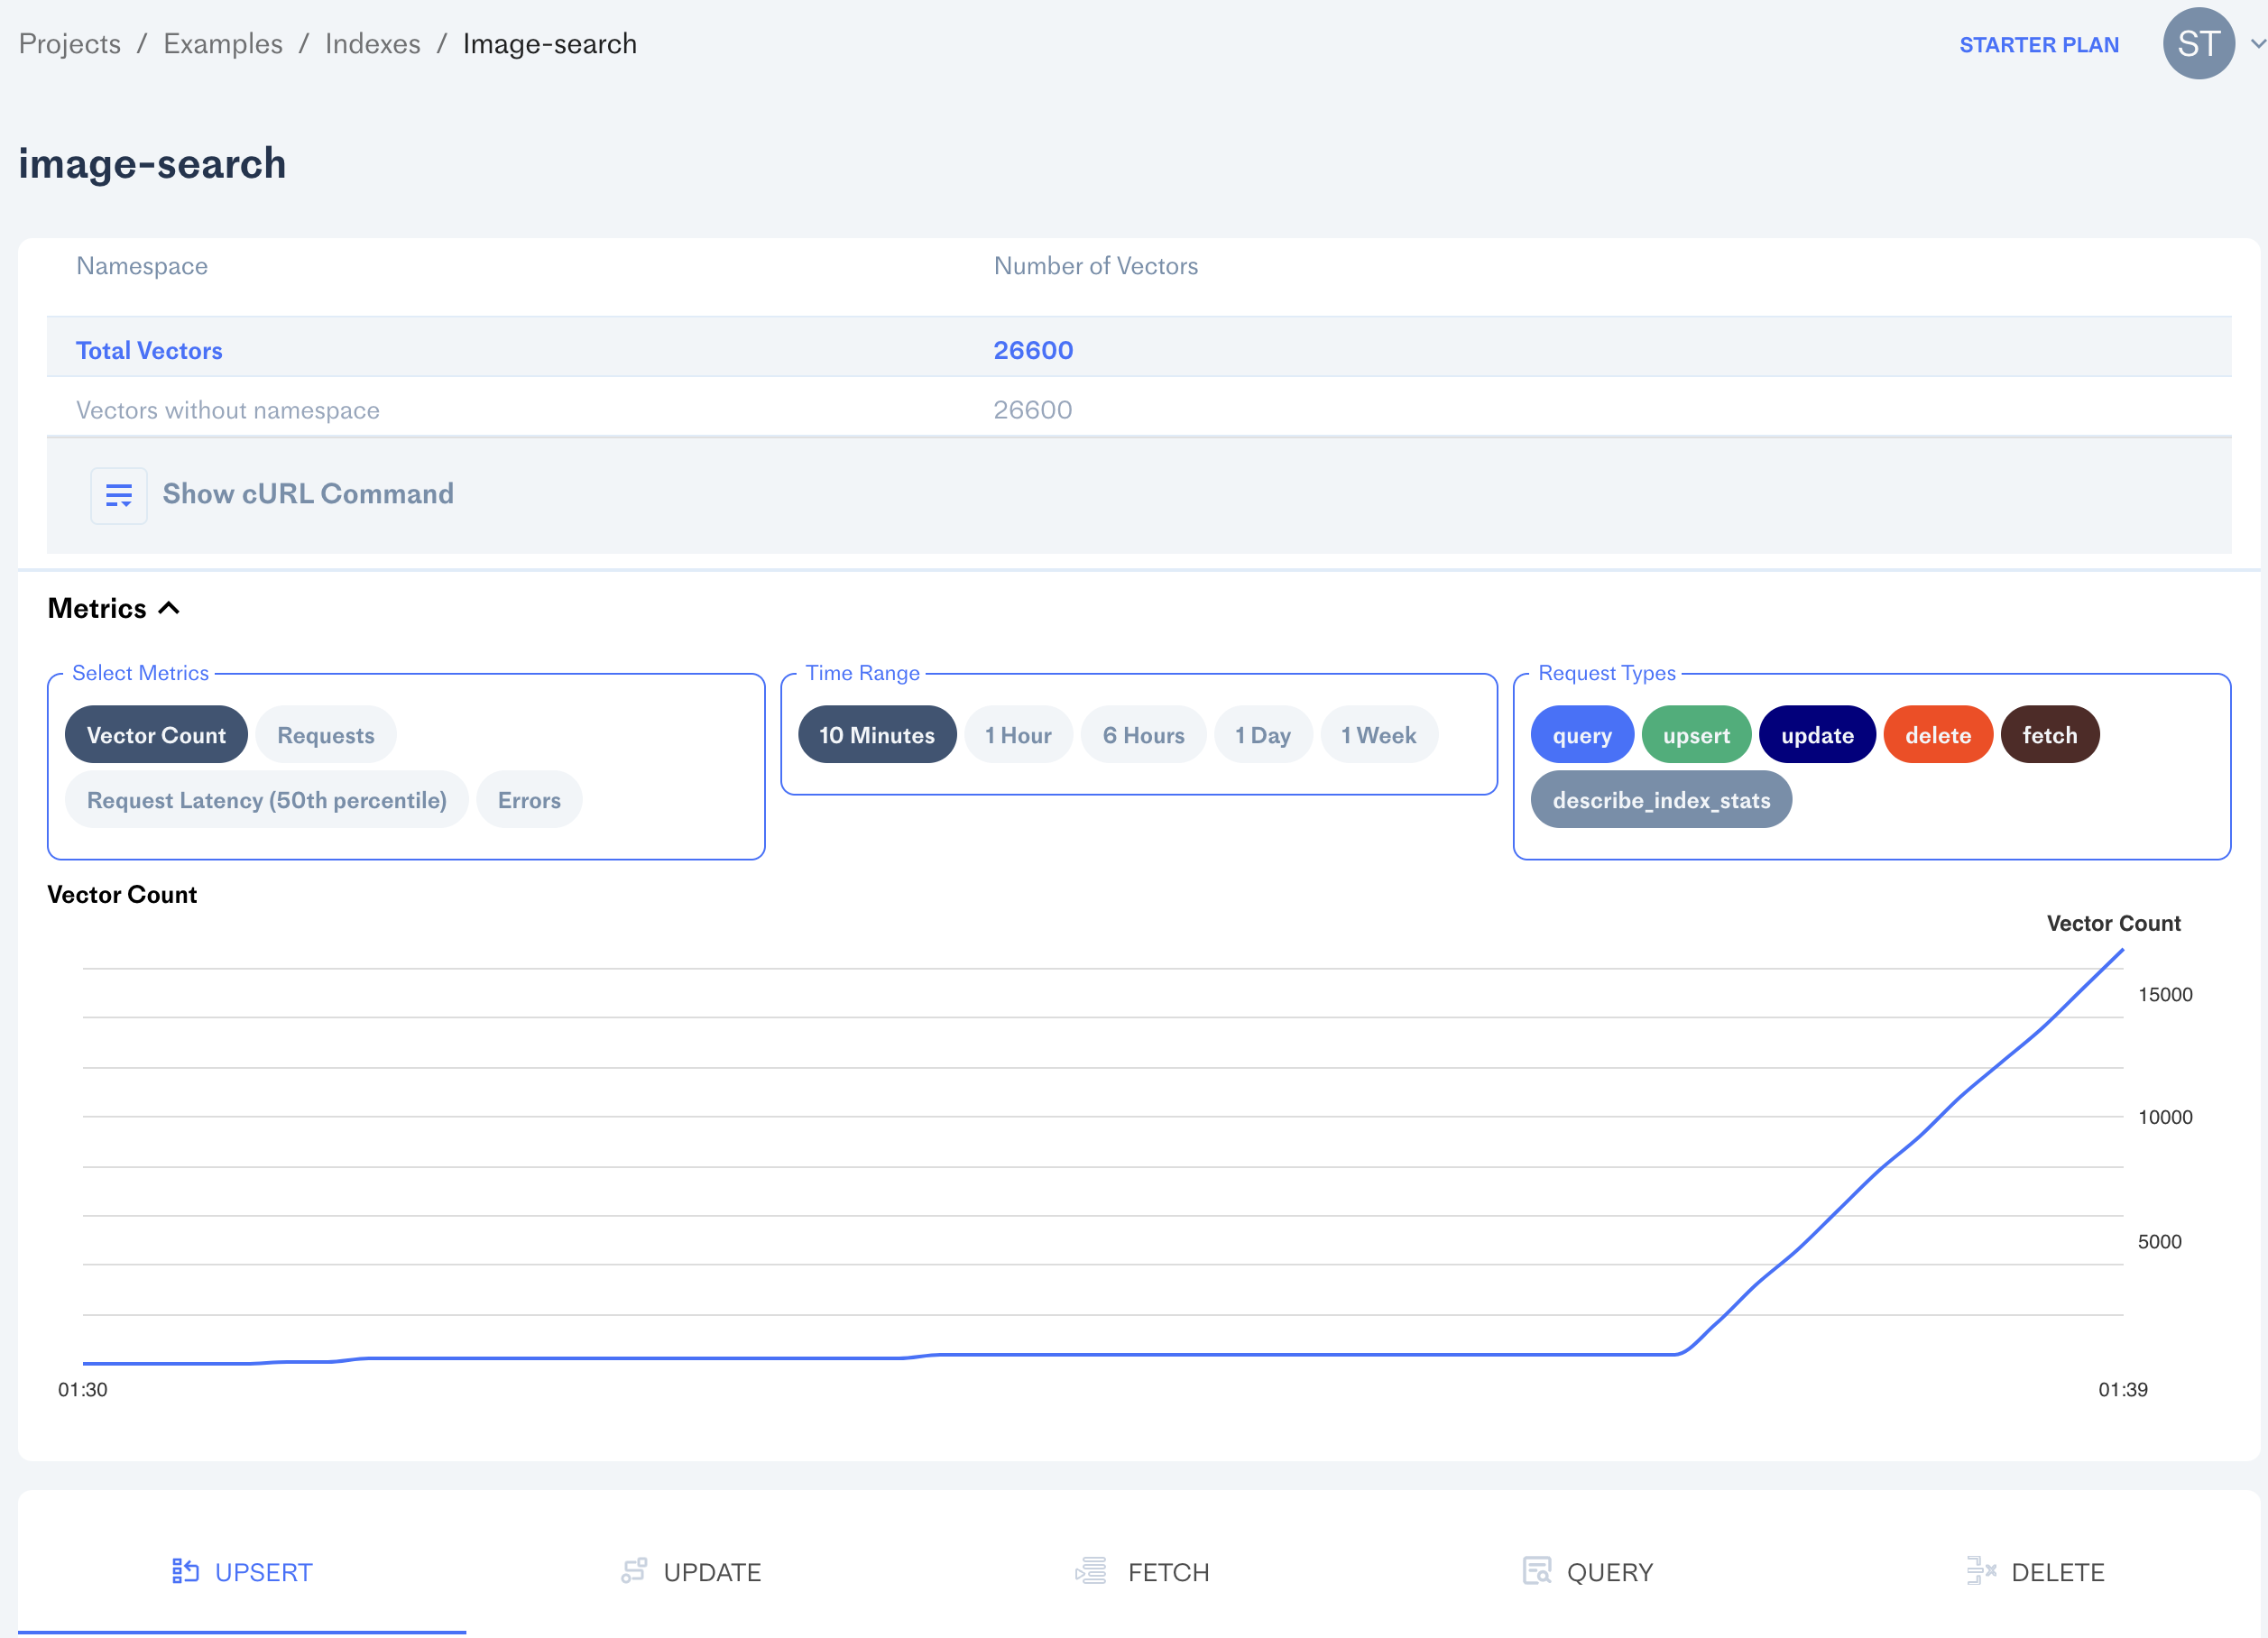

## Querying Pinecone

Now that all the embeddings of the images are on Pinecone's database, it's time to demonstrate Pinecone's lightning fast query capabilities.

###  Pinecone Example Usage

In the below example we query Pinecone's API with an embedding of a query image to return the vector embeddings that have the highest similarity score. Pinecone effeciently estimates which of the uploaded vector embeddings have the highest similarity when paired with the query term's embedding, and the database will scale to billions of embeddings maintaining low-latency and high throughput. In this example we have upserted 100,000 embeddings. Our starter plan supports up to one million.

#### Example: Pinecone API Request and Response

Let's find images similar to the `query_image` variable, shown below.

#### Example Query Image

#### A sample image

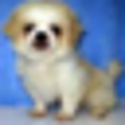

In [14]:
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog4.png'
r = requests.get(url, stream=True)
query_image = Image.open(r.raw)
h.printmd("#### A sample image")
query_image.resize((125,125))

In [15]:
query_embedding = model(h.preprocess(query_image).unsqueeze(0)).tolist()
response = index.query(query_embedding, top_k=4, include_metadata=True)
h.printmd(f"#### A sample response from Pinecone \n ==============\n \n")
h.printmd(f"```python\n{response}\n```")

#### A sample response from Pinecone 
 ==============
 


```python
{'matches': [{'id': 'CIFAR10.11519',
              'metadata': {'label': 'dog'},
              'score': 1.00000012,
              'values': []},
             {'id': 'CIFAR10.21059',
              'metadata': {'label': 'dog'},
              'score': 0.982942224,
              'values': []},
             {'id': 'CIFAR10.48510',
              'metadata': {'label': 'dog'},
              'score': 0.982879698,
              'values': []},
             {'id': 'CIFAR100.32560',
              'metadata': {'label': 'seal'},
              'score': 0.982618093,
              'values': []}],
 'namespace': ''}
```

#### Enriched Response
In the next few lines, we look up the actual images associated to the vector embeddings.

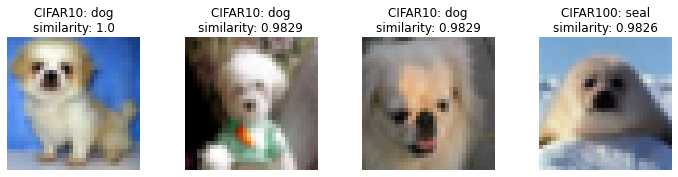

In [16]:
h.show_response_as_grid(response, datasets, 1, 4, figsize=(10, 10))

#### Results

We invite the reader to explore various queries to see how they come up. In the one above, we chose one of the CIFAR-10 images as the query image. Note that the query image embedding need not exist in your Pinecone index in order to find similar images. Additionally, the search results are only as good as the embeddings, which are based on the quality and quantity of the images as well as how expressive the model used is. There are plenty of other out of the box, pretrained models in PyTorch and elsewhere!

### Pinecone Example Usage with Metadata

Extensive predicate logic can be applied to metadata filtering, just like the [WHERE clause](https://www.pinecone.io/learn/vector-search-filtering/) in SQL! Pinecone's [metadata feature](https://www.pinecone.io/docs/metadata-filtering/) provides easy-to-implement filtering.

#### Example using Metadata

For demonstration, let's use metadata to find all images classified as a _seal_ that look like the `query_image` variable shown above.

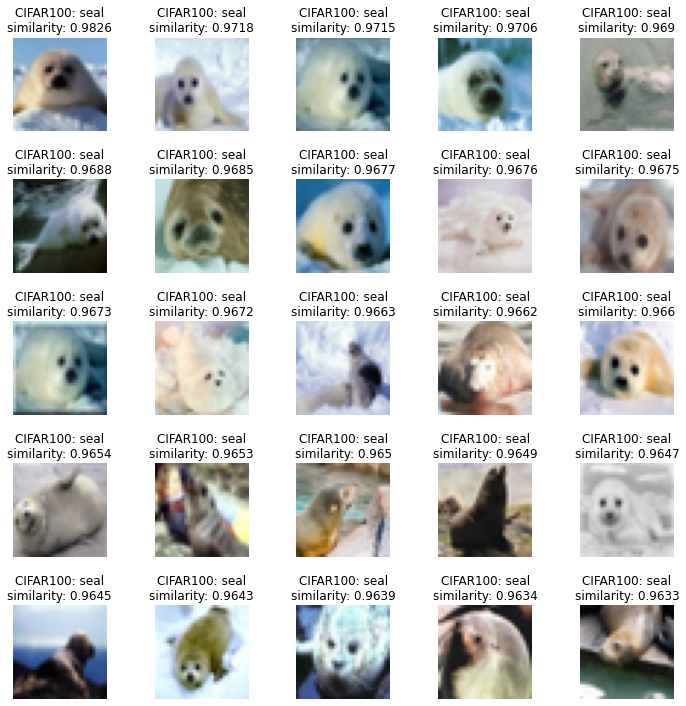

In [17]:
response = index.query(
    query_embedding, 
    top_k=25, 
    filter={"label": {"$eq": "seal"}},
    include_metadata=True
)
h.show_response_as_grid(response, datasets, 5, 5, figsize=(10, 10))

#### Results

All of the results returned are indeed seals, and many of them do look like the query image! Note how the cosine similarity scores are returned in descending order.

#### Additional Note On Querying Pinecone

In this example, you queried your Pinecone index with an embedding that was already in the index, however that is not necessary at all. For this index, _any 1000-dimensional embedding_ can be used to query Pinecone.

## Conclusion

In this example, we demonstrated how Pinecone makes it possible to do realtime image similarity search using a pre-trained computer vision model! We also demonstrated the use of metadata filtering with querying Pinecone's vector database.

### Like what you see? Explore our [community](https://www.pinecone.io/community/) 

Learn more about semantic search and the rich, performant, and production-level feature set of Pinecone's Vector Database by visiting https://pinecone.io, connecting with us [here](https://www.pinecone.io/contact/) and following us on [LinkedIn](https://www.linkedin.com/company/pinecone-io). If interested in some of the algorithms that allow for effecient estimation of similar vectors, visit our Algorithms and Libraries section of our [Learning Center](https://www.pinecone.io/learn/).